In [89]:
# Core imports (restored from v1_35)
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utilities
import joblib
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:.3f}")


# Modelo de Previsão de Preço de Aluguel

## Versão Completa com Análise Exploratória Completa -  v1.35


## 1. Importação de Bibliotecas e Configuração

In [90]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Plotly (guarded)
plotly_available = False
try:
    import plotly.express as px
    import plotly.graph_objects as go
    plotly_available = True
except Exception as e:
    print('Plotly not available, skipping Plotly-based charts:', e)


## 2. Carregar Dados do Google Drive

In [91]:
# Mount Google Drive (skip outside Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print('Skipping Google Drive mount:', e)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# Load the dataset (prefer local workspace path)
import os
local_path = 'docsk/published_listing_Sep2025.csv'
colab_path = '/content/drive/MyDrive/AI/price_prediction/published_listing_Sep2025.csv'
data_path = local_path if os.path.exists(local_path) else colab_path
print(f'Dataset path: {data_path}')
dataset = pd.read_csv(data_path)

print(f"Dataset carregado com sucesso!")
print(f"Shape: {dataset.shape}")
print(f"Uso de memória: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns ({len(dataset.columns)}):")
print(dataset.columns.tolist())


Dataset path: /content/drive/MyDrive/Machobear/AI/price_prediction/published_listing_Sep2025.csv
Dataset carregado com sucesso!
Shape: (5857, 24)
Uso de memória: 3.38 MB

Columns (24):
['longitude', 'latitude', 'neighborhood', 'city', 'state', 'year_built', 'construction_type', 'building_type_txt_id', 'student_friendly', 'total_rooms', 'total_bathrooms', 'size', 'count_balconies', 'verified_state_machine', 'allow_pets', 'allow_smoking', 'furnished', 'count_private_parking', 'transit_distance', 'lease_type', 'rental_type', 'price_frequency', 'price_monthly', 'price']


## 3. Exploração Inicial dos Dados

In [93]:
# Display first few rows
dataset.head()

,longitude,latitude,neighborhood,city,state,year_built,construction_type,building_type_txt_id,student_friendly,total_rooms,total_bathrooms,size,count_balconies,verified_state_machine,allow_pets,allow_smoking,furnished,count_private_parking,transit_distance,lease_type,rental_type,price_frequency,price_monthly,price
0,-123.127,49.278,Downtown,Vancouver,BC,2010.000,Concrete,highrise,0,1.000,1.000,659.000,NaN,approved,1,0.000,1.000,NaN,NaN,month_to_month,short_term,monthly,3695.000,3695.000
1,-123.125,49.289,Coal Harbour,Vancouver,BC,1996.000,concrete,highrise,0,1.000,1.000,550.000,NaN,approved,1,0.000,1.000,NaN,NaN,month_to_month,short_term,monthly,3250.000,3250.000
2,-123.128,49.274,Yaletown,Vancouver,BC,2004.000,concrete,highrise,0,1.000,1.000,750.000,NaN,approved,1,0.000,1.000,NaN,NaN,month_to_month,long_term,monthly,3750.000,3750.000
3,-123.124,49.281,Downtown,Vancouver,BC,2005.000,concrete,highrise,0,1.000,1.000,650.000,NaN,approved,1,0.000,1.000,NaN,NaN,month_to_month,short_term,monthly,3495.000,3495.000
4,-123.124,49.288,Coal Harbour,Vancouver,BC,2007.000,concrete,highrise,0,2.000,2.000,900.000,NaN,approved,1,0.000,1.000,NaN,NaN,month_to_month,long_term,monthly,4800.000,4800.000


In [94]:
# Data types and missing values
info_df = pd.DataFrame({
    'Column': dataset.columns,
    'Type': dataset.dtypes,
    'Non-Null Count': dataset.count(),
    'Null Count': dataset.isnull().sum(),
    'Null %': (dataset.isnull().sum() / len(dataset)) * 100,
    'Unique Values': dataset.nunique()
})

print("\nDataset Information:")
print(info_df.sort_values('Null %', ascending=False))


Dataset Information:
                                        Column     Type  Non-Null Count  \
transit_distance              transit_distance  float64               0   
count_balconies                count_balconies  float64               0   
construction_type            construction_type   object             805   
year_built                          year_built  float64            1779   
count_private_parking    count_private_parking  float64            2300   
neighborhood                      neighborhood   object            5201   
size                                      size  float64            5202   
furnished                            furnished  float64            5305   
total_rooms                        total_rooms  float64            5566   
price                                    price  float64            5682   
price_monthly                    price_monthly  float64            5682   
allow_smoking                    allow_smoking  float64            5821   
lon

In [95]:
# Explore the ctagoeries in lease_type and price_frequency
print("\nCategories in lease_type:")
print(dataset['lease_type'].value_counts())

print("\nCategories in price_frequency:")
print(dataset['price_frequency'].value_counts())


Categories in lease_type:
lease_type
fixed             5386
month_to_month     471
Name: count, dtype: int64

Categories in price_frequency:
price_frequency
monthly     5712
daily        135
one_time       6
weekly         4
Name: count, dtype: int64


In [96]:
# Statistical summary
dataset.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
longitude,5857.000,NaN,NaN,NaN,-107.352,20.320,-125.275,-123.087,-122.757,-79.814,-52.815
latitude,5857.000,NaN,NaN,NaN,47.917,3.177,25.847,45.370,49.210,49.279,56.757
neighborhood,5201,766,Downtown,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,5857,210,Vancouver,1247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,5857,18,BC,3220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_built,1779.000,NaN,NaN,NaN,2000.971,101.333,0.000,2000.000,2015.000,2021.000,2026.000
construction_type,805,19,concrete,361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
building_type_txt_id,5857,4,highrise,4071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
student_friendly,5857.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000
total_rooms,5566.000,NaN,NaN,NaN,1.713,1.002,0.000,1.000,2.000,2.000,10.000


## 4. Limpeza de Dados

In [97]:
# Remove duplicates
print(f"Antes de remover duplicatas: {len(dataset)}")
dataset = dataset.drop_duplicates()
print(f"Após remover duplicatas: {len(dataset)}")
print(f"Removido {len(dataset) - len(dataset.drop_duplicates())} linhas duplicadas")

Antes de remover duplicatas: 5857
Após remover duplicatas: 5799
Removido 0 linhas duplicadas


In [98]:
# Remove price_frequency different than monthly
print(f"Antes de remover preços não mensais: {len(dataset)}")
dataset = dataset[dataset['price_frequency'] == 'monthly']
print(f"Após remover preços não mensais: {len(dataset)}")

# Remove lease_type different than fixed
print(f"Antes de remover contratos não fixos: {len(dataset)}")
dataset = dataset[dataset['lease_type'] == 'fixed']
print(f"Após remover contratos não fixos: {len(dataset)}")

Antes de remover preços não mensais: 5799
Após remover preços não mensais: 5656
Antes de remover contratos não fixos: 5656
Após remover contratos não fixos: 5310


In [99]:
# Keep only long-term rentals
print(f"Antes de remover aluguéis não de longo prazo: {len(dataset)}")
dataset = dataset[dataset['rental_type'] == 'long_term']
print(f"Após remover aluguéis não de longo prazo: {len(dataset)}")


Antes de remover aluguéis não de longo prazo: 5310
Após remover aluguéis não de longo prazo: 4744


In [100]:
# Remove columns with too many missing values (>90%)
missing_threshold = 0.9
missing_ratio = dataset.isnull().sum() / len(dataset)
columns_to_drop = missing_ratio[missing_ratio > missing_threshold].index.tolist()

if columns_to_drop:
    print(f"Dropping columns with >{missing_threshold*100}% missing values:")
    for col in columns_to_drop:
        print(f"  - {col}: {missing_ratio[col]*100:.1f}% missing")
    dataset = dataset.drop(columns_to_drop, axis=1)
else:
    print("No columns with excessive missing values")

# Also drop specific columns known to be problematic
problematic_cols = ['year_built', 'construction_type', 'count_balconies', 'transit_distance']
existing_problematic = [col for col in problematic_cols if col in dataset.columns]
if existing_problematic:
    dataset = dataset.drop(existing_problematic, axis=1)
    print(f"Dropped problematic columns: {existing_problematic}")

Dropping columns with >90.0% missing values:
  - count_balconies: 100.0% missing
  - transit_distance: 100.0% missing
Dropped problematic columns: ['year_built', 'construction_type']


In [101]:
# Remove from the dataset where the Province/State is not a Canadian Province
print(f"Antes de remover províncias não canadenses: {len(dataset)}")
canadian_provinces = ['BC', 'AB', 'SK', 'MB', 'ON', 'QC', 'NB', 'NS', 'PE', 'NL', 'YT', 'NT', 'NU']
dataset = dataset[dataset['state'].isin(canadian_provinces)]
print(f"Após remover províncias não canadenses: {len(dataset)}")


Antes de remover províncias não canadenses: 4744
Após remover províncias não canadenses: 4742


## 5. Análise da Variável Alvo

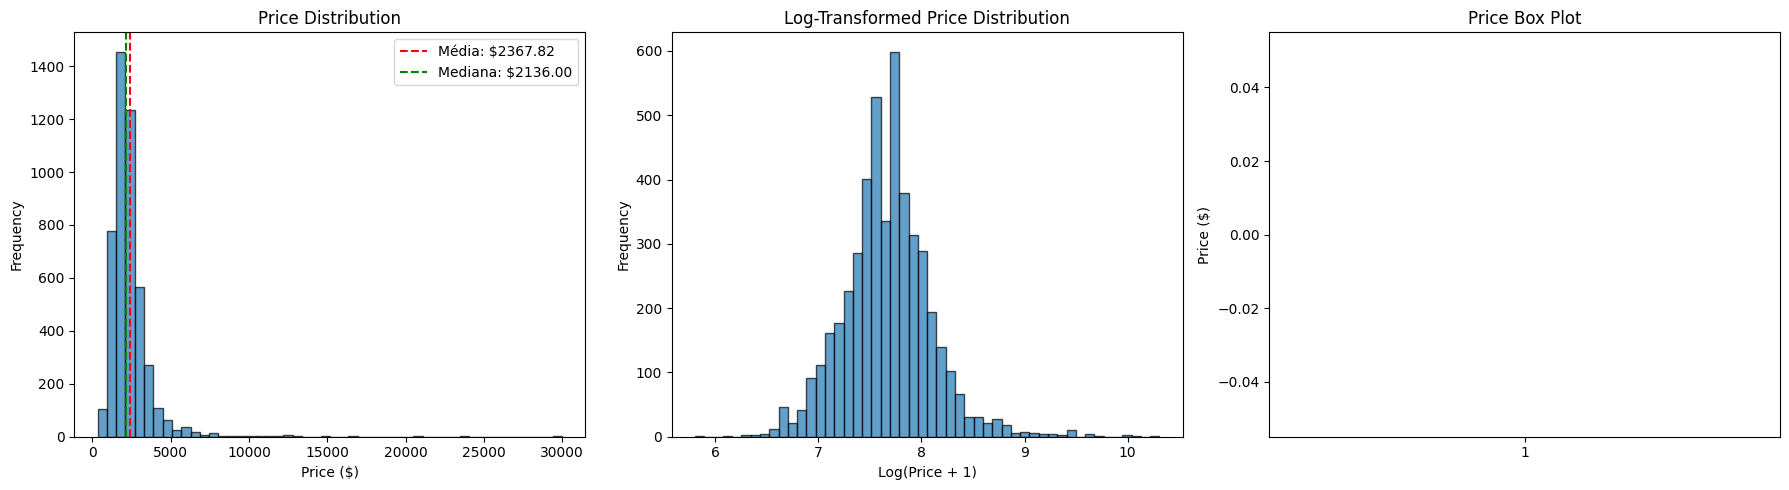

Estatísticas de Preço:
  Média: $2367.82
  Mediana: $2136.00
  Desvio Padrão: $1411.96
  Mínimo: $330.00
  Máximo: $30000.00


In [102]:
# Price distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(dataset['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')
axes[0].axvline(dataset['price'].mean(), color='red', linestyle='--', label=f'Média: ${dataset["price"].mean():.2f}')
axes[0].axvline(dataset['price'].median(), color='green', linestyle='--', label=f'Mediana: ${dataset["price"].median():.2f}')
axes[0].legend()

# Log-transformed histogram
axes[1].hist(np.log1p(dataset['price']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Price Distribution')

# Box plot
axes[2].boxplot(dataset['price'])
axes[2].set_ylabel('Price ($)')
axes[2].set_title('Price Box Plot')

plt.tight_layout()
plt.show()

print(f"Estatísticas de Preço:")
print(f"  Média: ${dataset['price'].mean():.2f}")
print(f"  Mediana: ${dataset['price'].median():.2f}")
print(f"  Desvio Padrão: ${dataset['price'].std():.2f}")
print(f"  Mínimo: ${dataset['price'].min():.2f}")
print(f"  Máximo: ${dataset['price'].max():.2f}")

## 6. Detecção e Remoção de Outliers

In [103]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in price
price_outliers, price_lower, price_upper = detect_outliers_iqr(dataset, 'price', multiplier=3)
print(f"Outliers de preço detectados: {len(price_outliers)}")
print(f"Price bounds: ${price_lower:.2f} - ${price_upper:.2f}")

# Detect outliers in number of rooms
room_outliers, room_lower, room_upper = detect_outliers_iqr(dataset, 'total_rooms', multiplier=3)
print(f"Outliers de quartos detectados: {len(room_outliers)}")
print(f"Room bounds: {room_lower} - {room_upper}")

# Detect outliers in number of bathrooms
bathroom_outliers, bathroom_lower, bathroom_upper = detect_outliers_iqr(dataset, 'total_bathrooms', multiplier=3)
print(f"Outliers de banheiros detectados: {len(bathroom_outliers)}")
print(f"Bathroom bounds: {bathroom_lower} - {bathroom_upper}")

# Remove extreme outliers
print(f"\nAntes da remoção de outliers: {len(dataset)}")
dataset = dataset[(dataset['price'] >= 100) & (dataset['price'] <= 10000)]
print(f"Após remoção de outliers de preço (100-10000): {len(dataset)}")

Outliers de preço detectados: 107
Price bounds: $-1400.00 - $5775.00
Outliers de quartos detectados: 23
Room bounds: -2.0 - 5.0
Outliers de banheiros detectados: 51
Bathroom bounds: -2.0 - 5.0

Antes da remoção de outliers: 4742
Após remoção de outliers de preço (100-10000): 4685


In [104]:
# Outlier detection for numerical features
numerical_features = dataset.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('price')  # Already handled

outlier_summary = []
for feature in numerical_features:
    if dataset[feature].nunique() > 10:  # Only for continuous variables
        outliers, lower, upper = detect_outliers_iqr(dataset, feature, multiplier=3)
        outlier_summary.append({
            'Feature': feature,
            'Outliers': len(outliers),
            'Outliers %': (len(outliers) / len(dataset)) * 100,
            'Lower Bound': lower,
            'Upper Bound': upper
        })

outlier_df = pd.DataFrame(outlier_summary)
print("\nOutlier Summary for Numerical Features:")
print(outlier_df.sort_values('Outliers %', ascending=False))


Outlier Summary for Numerical Features:
           Feature  Outliers  Outliers %  Lower Bound  Upper Bound
3             size       127       2.711     -535.250     2032.000
4    price_monthly        73       1.558    -1436.000     5802.000
2  total_bathrooms        43       0.918       -2.000        5.000
0        longitude         0       0.000     -252.876       50.079
1         latitude         0       0.000       30.801       63.139


In [105]:
# Remove outliers for critical features
print("Removing outliers for geographical and size features...")

# Geographical bounds (North America)
before = len(dataset)
dataset = dataset[(dataset['latitude'] > 25) & (dataset['latitude'] < 60)]
dataset = dataset[(dataset['longitude'] > -130) & (dataset['longitude'] < -50)]
print(f"  Geographical outliers removed: {before - len(dataset)}")

# Tamanho bounds
before = len(dataset)
dataset = dataset[(dataset['size'] > 50) & (dataset['size'] < 5000)]
print(f"  Tamanho outliers removed: {before - len(dataset)}")

# Quartos
before = len(dataset)
dataset = dataset[(dataset['total_rooms'] >= 0) & (dataset['total_rooms'] <= 10)]
print(f"  Room outliers removed: {before - len(dataset)}")

# Bathrooms
before = len(dataset)
dataset = dataset[(dataset['total_bathrooms'] >= 0) & (dataset['total_bathrooms'] <= 6)]
print(f"  Bathroom outliers removed: {before - len(dataset)}")

print(f"\nFinal dataset size: {len(dataset)}")

Removing outliers for geographical and size features...
  Geographical outliers removed: 0
  Tamanho outliers removed: 499
  Room outliers removed: 92
  Bathroom outliers removed: 20

Final dataset size: 4074


## 7. Engenharia de Features

In [106]:
# Create new features
dataset['price_per_sqft'] = dataset['price'] / dataset['size']
dataset['rooms_per_bathroom'] = dataset['total_rooms'] / (dataset['total_bathrooms'] + 0.5)
dataset['has_parking'] = (dataset['count_private_parking'] > 0).astype(int)
dataset['is_large'] = (dataset['size'] > dataset['size'].median()).astype(int)

# Create size categories for stratification
dataset['size_category'] = pd.cut(dataset['size'],
                                  bins=[0, 400, 600, 800, 1000, 2000, np.inf],
                                  labels=['tiny', 'small', 'medium', 'large', 'xlarge', 'huge'])

# Create price categories for analysis
dataset['price_category'] = pd.cut(dataset['price'],
                                   bins=[0, 1000, 1500, 2000, 3000, np.inf],
                                   labels=['budget', 'economy', 'standard', 'premium', 'luxury'])

print("Engenharia de features concluída!")
print(f"Novas features criadas: price_per_sqft, rooms_per_bathroom, has_parking, is_large, size_category, price_category")

Engenharia de features concluída!
Novas features criadas: price_per_sqft, rooms_per_bathroom, has_parking, is_large, size_category, price_category


## 8. Análise Exploratória de Dados (EDA)

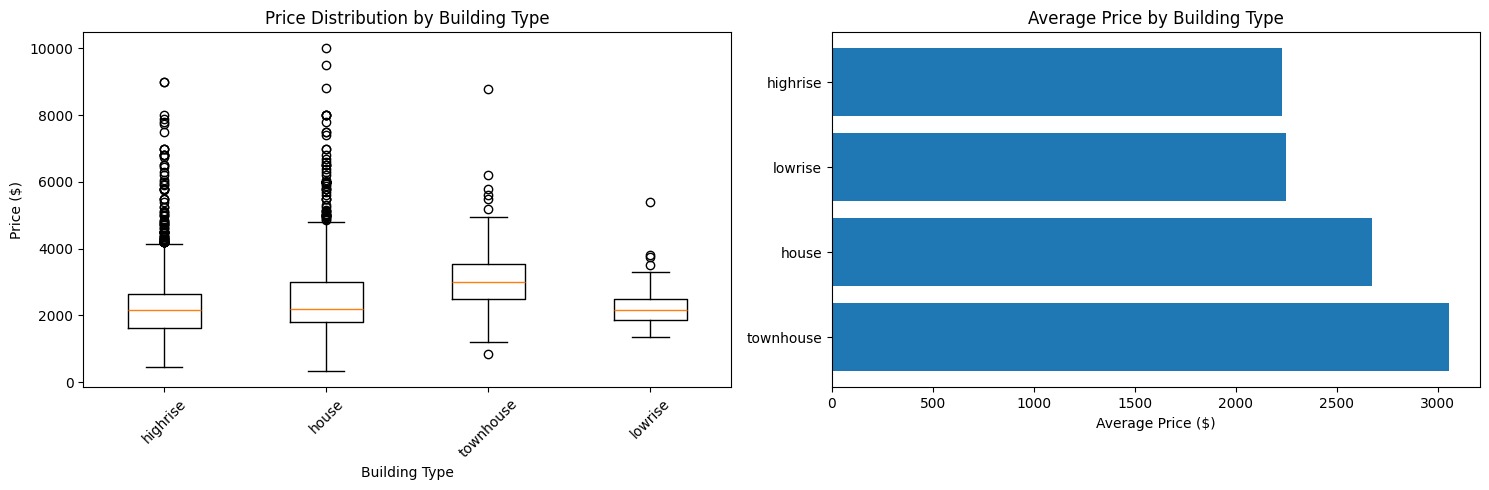

In [107]:
# Price by property type
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
building_types = dataset['building_type_txt_id'].value_counts().head(10).index
data_to_plot = [dataset[dataset['building_type_txt_id'] == bt]['price'].values
                for bt in building_types]
axes[0].boxplot(data_to_plot, labels=building_types)
axes[0].set_xlabel('Building Type')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price Distribution by Building Type')
axes[0].tick_params(axis='x', rotation=45)

# Average price
avg_price = dataset.groupby('building_type_txt_id')['price'].mean().sort_values(ascending=False).head(10)
axes[1].barh(avg_price.index, avg_price.values)
axes[1].set_xlabel('Average Price ($)')
axes[1].set_title('Average Price by Building Type')

plt.tight_layout()
plt.show()

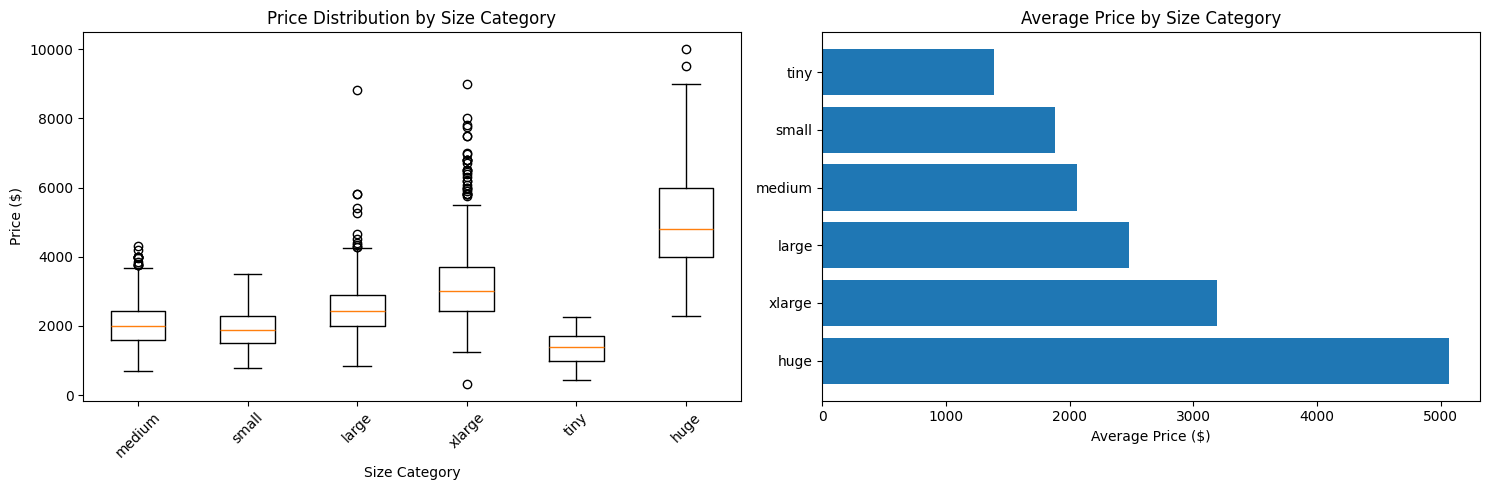

In [108]:
# Price distribution by size category
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
size_categories = dataset['size_category'].value_counts().head(10).index
data_to_plot = [dataset[dataset['size_category'] == bt]['price'].values
                for bt in size_categories]
axes[0].boxplot(data_to_plot, labels=size_categories)
axes[0].set_xlabel('Size Category')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price Distribution by Size Category')
axes[0].tick_params(axis='x', rotation=45)

# Average price
avg_price = dataset.groupby('size_category')['price'].mean().sort_values(ascending=False).head(10)
axes[1].barh(avg_price.index, avg_price.values)
axes[1].set_xlabel('Average Price ($)')
axes[1].set_title('Average Price by Size Category')

plt.tight_layout()
plt.show()


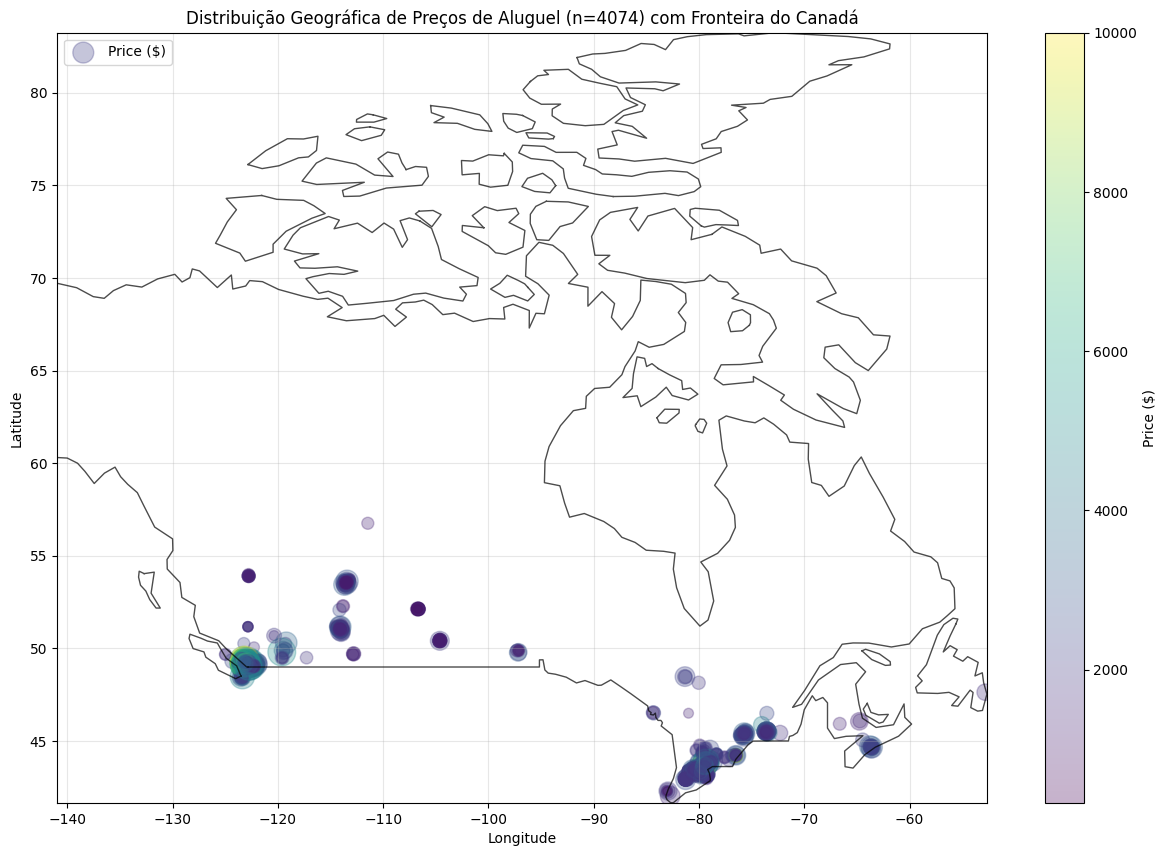

In [109]:
# Geographic distribution of prices with Canada boundary overlay (safe fallback)
try:
    import geopandas as gpd
    import os
    url = 'https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip'
    file_path = '/tmp/ne_110m_admin_0_countries.zip'
    # Try to download; if network blocked, this will raise
    import urllib.request
    urllib.request.urlretrieve(url, file_path)
    countries = gpd.read_file(f'zip://{file_path}')
    canada_geom = countries[countries['NAME'] == 'Canada'].geometry.values[0]
    bounds = canada_geom.bounds
    fig, ax = plt.subplots(figsize=(15, 10))
    if canada_geom.geom_type == 'MultiPolygon':
        for poly in canada_geom.geoms:
            x, y = poly.exterior.xy
            ax.plot(x, y, color='black', linewidth=1, alpha=0.7)
    elif canada_geom.geom_type == 'Polygon':
        x, y = canada_geom.exterior.xy
        ax.plot(x, y, color='black', linewidth=1, alpha=0.7)
    sample_size = min(5000, len(dataset))
    geo_sample = dataset.sample(n=sample_size, random_state=42)
    scatter = ax.scatter(geo_sample['longitude'], geo_sample['latitude'],
                         c=geo_sample['price'], cmap='viridis',
                         s=geo_sample['size'] / 10, alpha=0.3, label='Price ($)')
    plt.colorbar(scatter, label='Price ($)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Distribuição Geográfica de Preços de Aluguel (n={sample_size}) com Fronteira do Canadá')
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
except Exception as e:
    print('Skipping Canada boundary overlay due to error:', e)
    # Fallback: simple scatter without boundary
    plt.figure(figsize=(15, 10))
    sample_size = min(5000, len(dataset))
    geo_sample = dataset.sample(n=sample_size, random_state=42)
    scatter = plt.scatter(geo_sample['longitude'], geo_sample['latitude'],
                         c=geo_sample['price'], cmap='viridis', s=10, alpha=0.6)
    plt.colorbar(scatter, label='Price ($)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Distribuição Geográfica de Preços de Aluguel (n={sample_size})')
    plt.grid(True, alpha=0.3)
    plt.show()


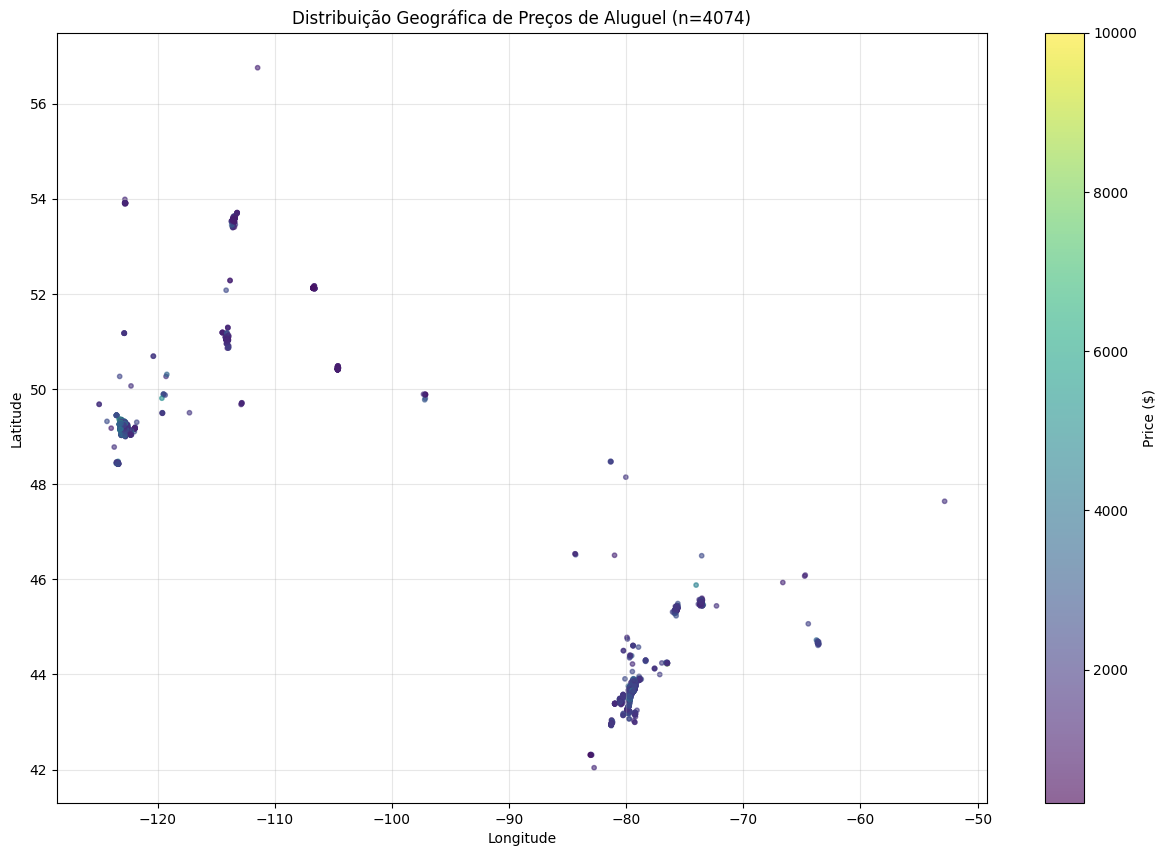

In [110]:
# Geographic distribution of prices
plt.figure(figsize=(15, 10))

# Amostra data for visualization (plotting all points might be too heavy)
sample_size = min(5000, len(dataset))
geo_sample = dataset.sample(n=sample_size, random_state=42)

scatter = plt.scatter(geo_sample['longitude'], geo_sample['latitude'],
                     c=geo_sample['price'], cmap='viridis',
                     s=10, alpha=0.6)
plt.colorbar(scatter, label='Price ($)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Distribuição Geográfica de Preços de Aluguel (n={sample_size})')
plt.grid(True, alpha=0.3)
plt.show()

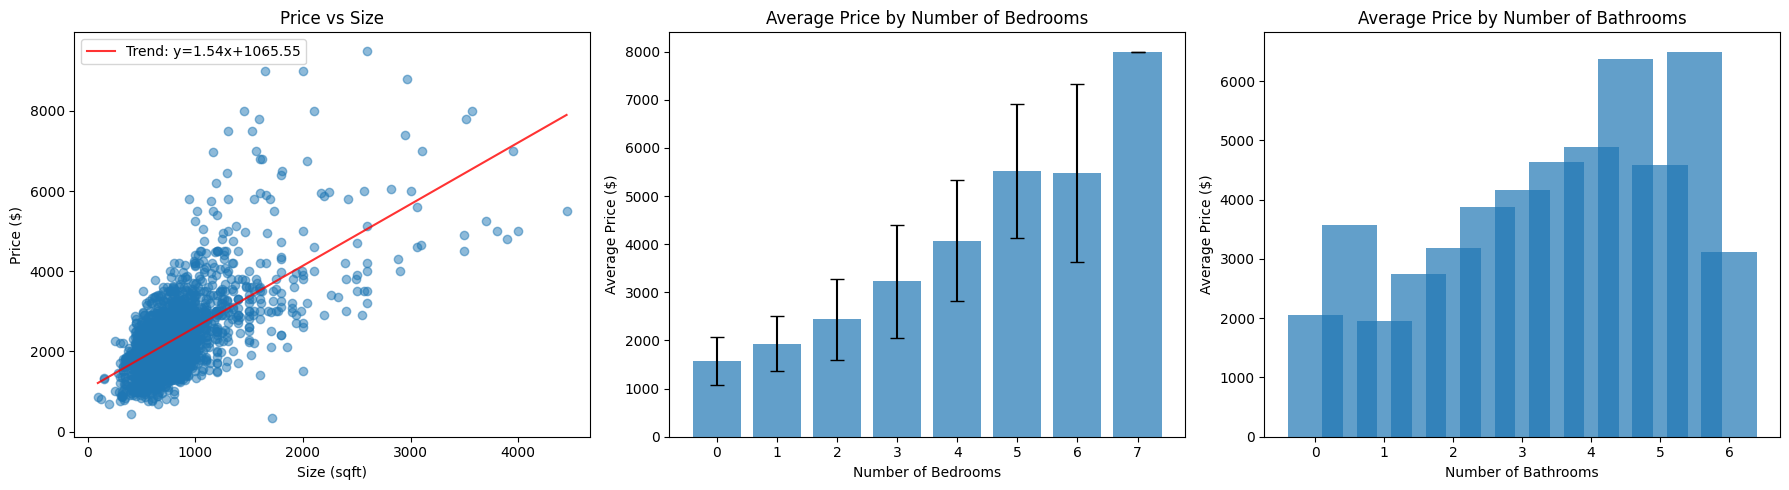

In [111]:
# Preço vs Tamanho relationship
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de dispersão
sample_data = dataset.sample(n=min(2000, len(dataset)), random_state=42)
axes[0].scatter(sample_data['size'], sample_data['price'], alpha=0.5)
axes[0].set_xlabel('Size (sqft)')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price vs Size')

# Add trend line
z = np.polyfit(sample_data['size'], sample_data['price'], 1)
p = np.poly1d(z)
axes[0].plot(sample_data['size'].sort_values(), p(sample_data['size'].sort_values()),
            "r-", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend()

# Price vs Bedrooms
bedroom_avg = dataset.groupby('total_rooms')['price'].agg(['mean', 'median', 'std'])
x_pos = bedroom_avg.index
axes[1].bar(x_pos, bedroom_avg['mean'], yerr=bedroom_avg['std'], capsize=5, alpha=0.7)
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Average Price ($)')
axes[1].set_title('Average Price by Number of Bedrooms')

# Price vs Bathrooms
bathroom_avg = dataset.groupby('total_bathrooms')['price'].mean()
axes[2].bar(bathroom_avg.index, bathroom_avg.values, alpha=0.7)
axes[2].set_xlabel('Number of Bathrooms')
axes[2].set_ylabel('Average Price ($)')
axes[2].set_title('Average Price by Number of Bathrooms')

plt.tight_layout()
plt.show()

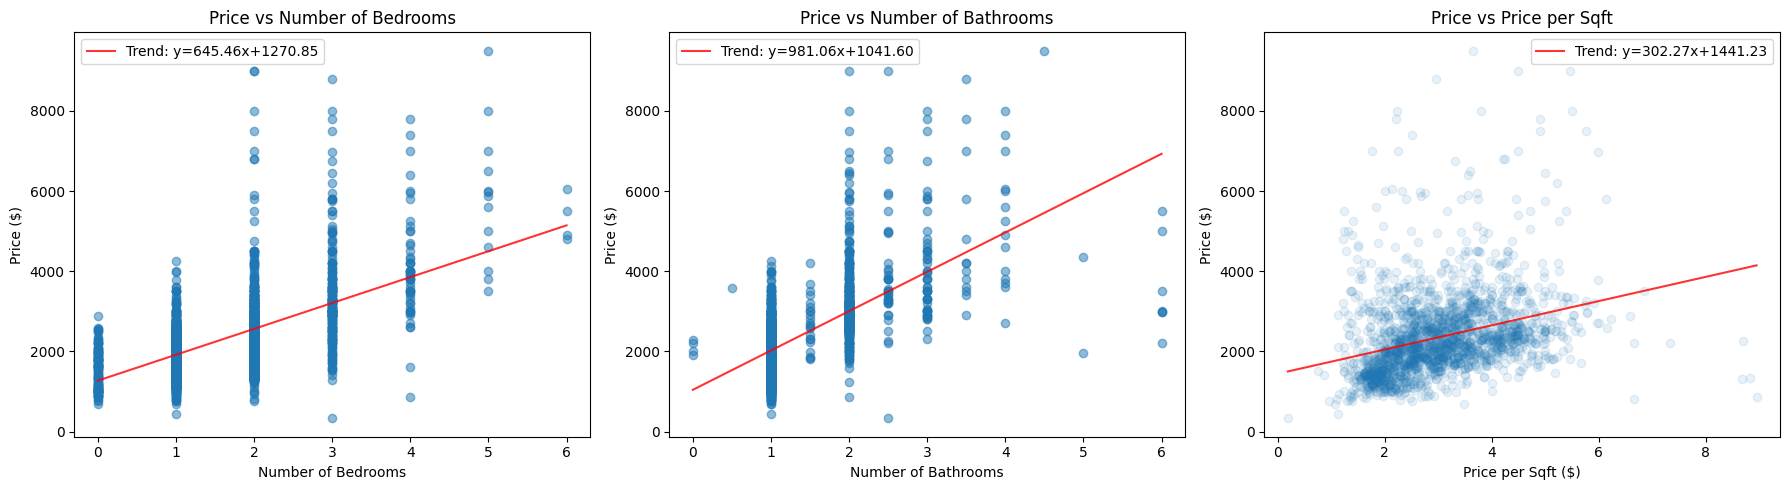

In [112]:
# Preço vs Número de Quartos, Bathrooms, and Price per Sqft relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de dispersão for Price vs Bedrooms
sample_data = dataset.sample(n=min(2000, len(dataset)), random_state=42)
axes[0].scatter(sample_data['total_rooms'], sample_data['price'], alpha=0.5)
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price vs Number of Bedrooms')

# Add trend line for Price vs Bedrooms
z_rooms = np.polyfit(sample_data['total_rooms'], sample_data['price'], 1)
p_rooms = np.poly1d(z_rooms)
axes[0].plot(sample_data['total_rooms'].sort_values(), p_rooms(sample_data['total_rooms'].sort_values()),
            "r-", alpha=0.8, label=f'Trend: y={z_rooms[0]:.2f}x+{z_rooms[1]:.2f}')
axes[0].legend()


# Gráfico de dispersão for Price vs Bathrooms
axes[1].scatter(sample_data['total_bathrooms'], sample_data['price'], alpha=0.5)
axes[1].set_xlabel('Number of Bathrooms')
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Price vs Number of Bathrooms')

# Add trend line for Price vs Bathrooms
z_bathrooms = np.polyfit(sample_data['total_bathrooms'], sample_data['price'], 1)
p_bathrooms = np.poly1d(z_bathrooms)
axes[1].plot(sample_data['total_bathrooms'].sort_values(), p_bathrooms(sample_data['total_bathrooms'].sort_values()),
            "r-", alpha=0.8, label=f'Trend: y={z_bathrooms[0]:.2f}x+{z_bathrooms[1]:.2f}')
axes[1].legend()


# Gráfico de dispersão for Preço vs Preço por m²
axes[2].scatter(sample_data['price_per_sqft'], sample_data['price'], alpha=0.1)
axes[2].set_xlabel('Price per Sqft ($)')
axes[2].set_ylabel('Price ($)')
axes[2].set_title('Price vs Price per Sqft')

# Add trend line for Preço vs Preço por m²
# Note: Price per Sqft might have outliers that affect the trend line,
# consider log transform or robust regression for a better fit if needed.
z_ppsf = np.polyfit(sample_data['price_per_sqft'], sample_data['price'], 1)
p_ppsf = np.poly1d(z_ppsf)
axes[2].plot(sample_data['price_per_sqft'].sort_values(), p_ppsf(sample_data['price_per_sqft'].sort_values()),
            "r-", alpha=0.8, label=f'Trend: y={z_ppsf[0]:.2f}x+{z_ppsf[1]:.2f}')
axes[2].legend()


plt.tight_layout()
plt.show()

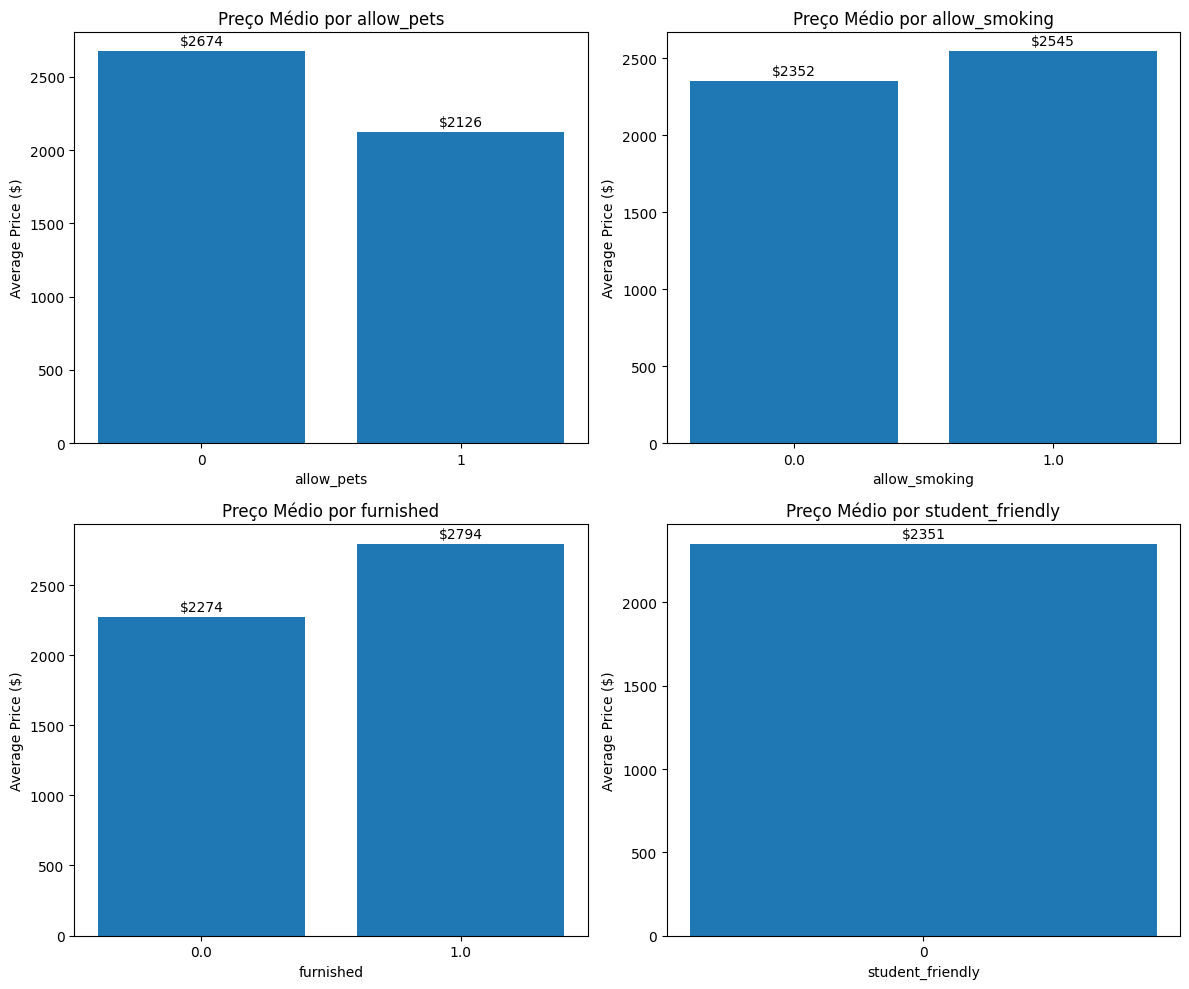

In [113]:
# Analyze categorical features impact on price
categorical_features = ['allow_pets', 'allow_smoking', 'furnished', 'student_friendly']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if feature in dataset.columns:
        data_grouped = dataset.groupby(feature)['price'].mean()
        axes[i].bar(data_grouped.index.astype(str), data_grouped.values)
        axes[i].set_title(f'Preço Médio por {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Average Price ($)')

        # Add value labels on bars
        for j, v in enumerate(data_grouped.values):
            axes[i].text(j, v + 20, f'${v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 9. Análise de Correlação

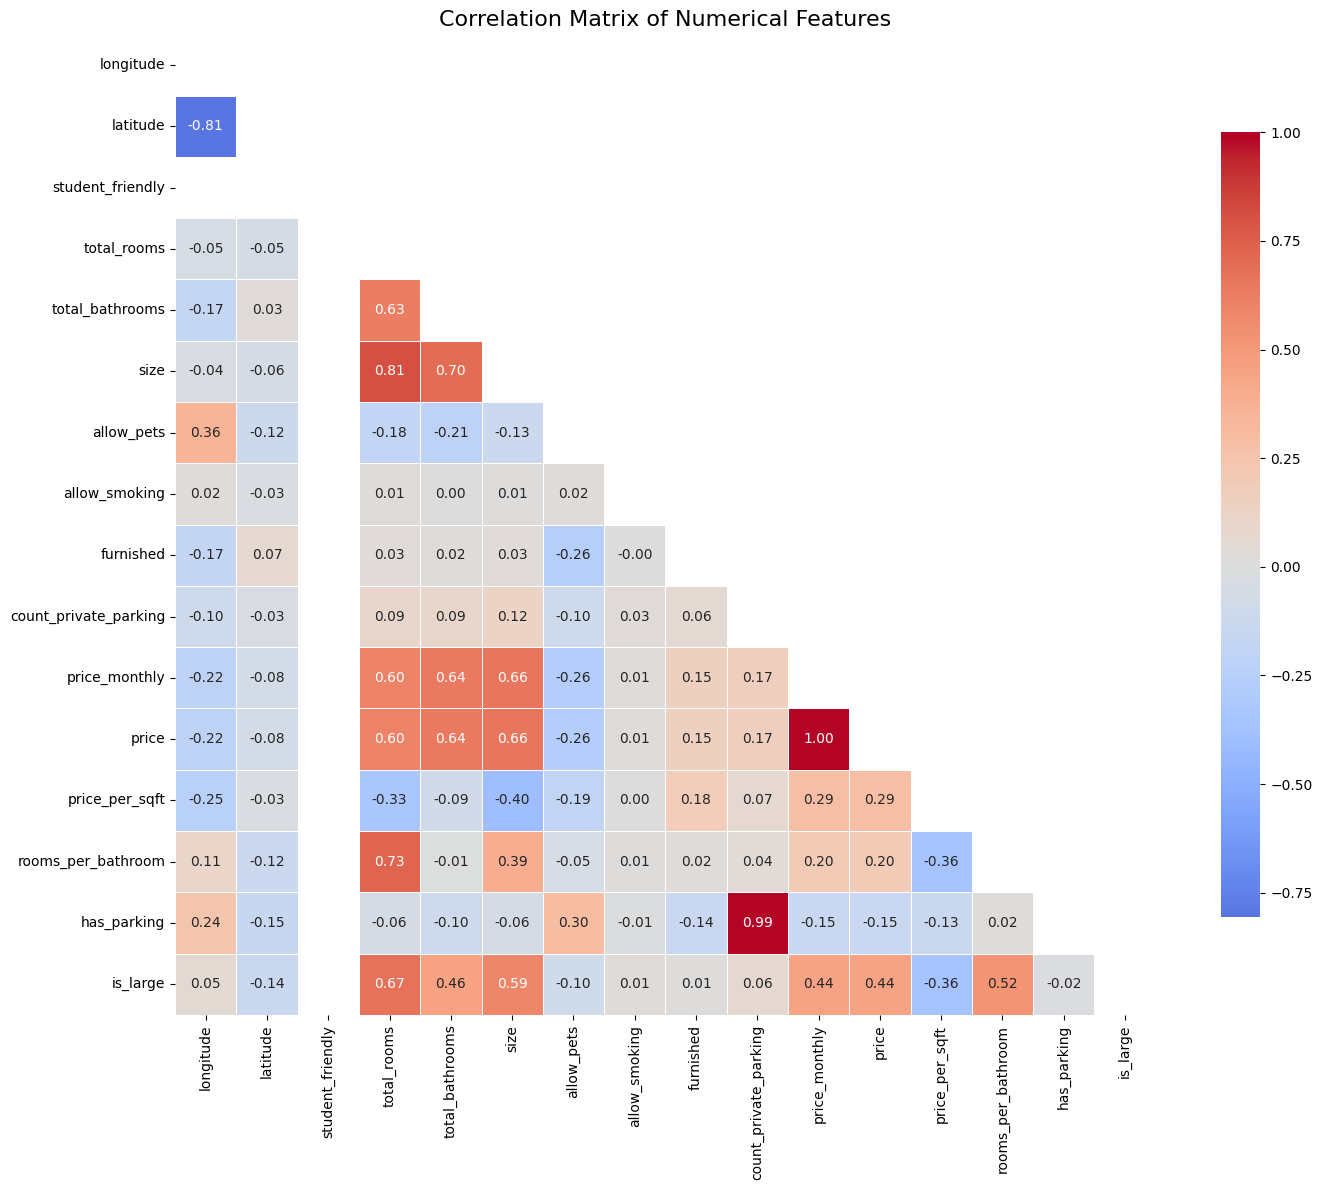


Features mais correlacionadas com preço:
price_monthly           1.000
size                    0.661
total_bathrooms         0.643
total_rooms             0.603
is_large                0.445
price_per_sqft          0.288
rooms_per_bathroom      0.196
count_private_parking   0.171
furnished               0.150
allow_smoking           0.014
Name: price, dtype: float64


In [114]:
# Select numerical features for correlation
numerical_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = dataset[numerical_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Show features most correlated with price
price_corr = correlation_matrix['price'].sort_values(ascending=False)
print("\nFeatures mais correlacionadas com preço:")
print(price_corr[1:11])  # Exclude price itself

## 10. Análise de Distribuição de Features

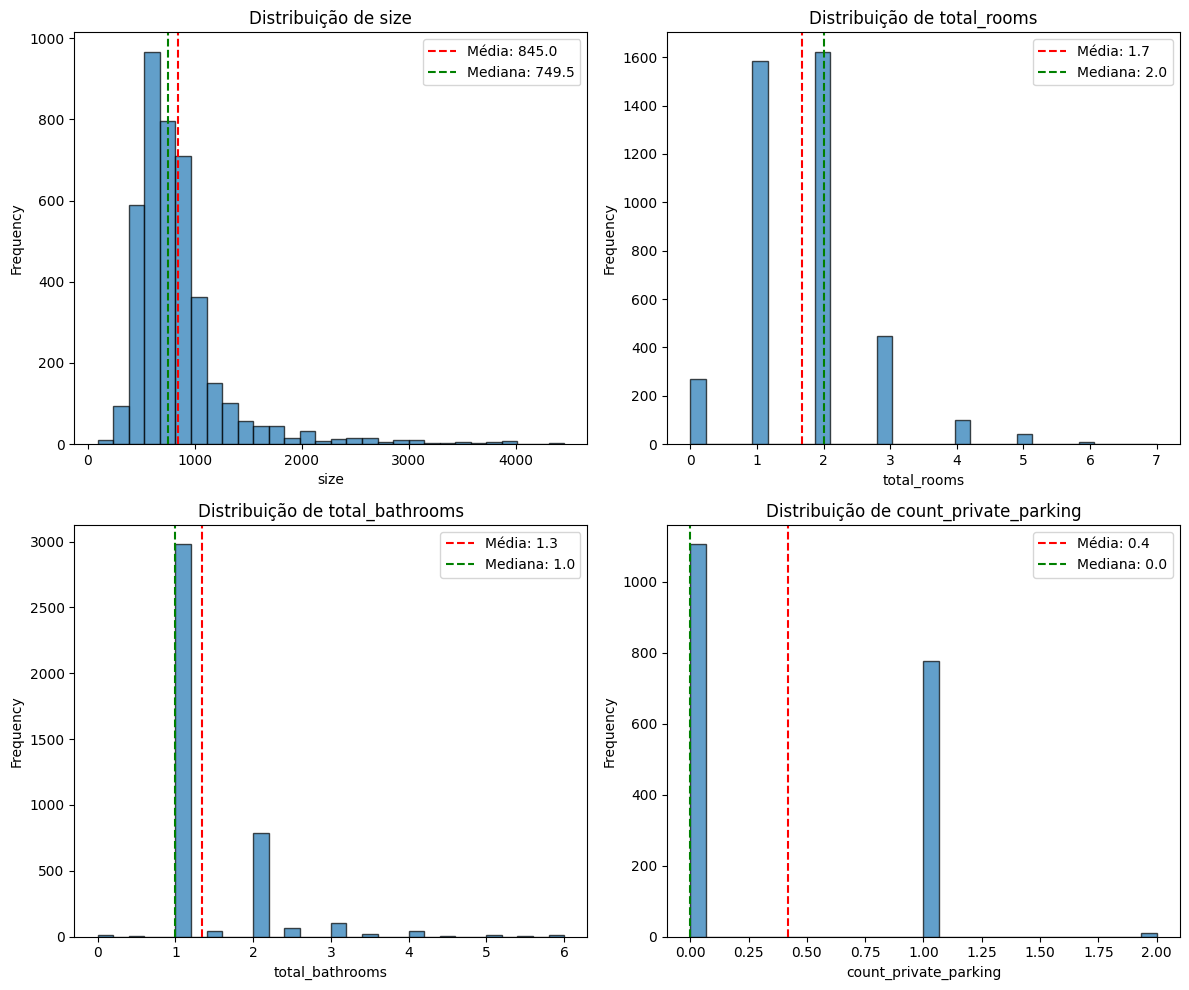

In [115]:
# Distribuição de key numerical features
features_to_plot = ['size', 'total_rooms', 'total_bathrooms', 'count_private_parking']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, feature in enumerate(features_to_plot):
    if feature in dataset.columns:
        axes[i].hist(dataset[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribuição de {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

        # Add statistics
        mean_val = dataset[feature].mean()
        median_val = dataset[feature].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Média: {mean_val:.1f}')
        axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

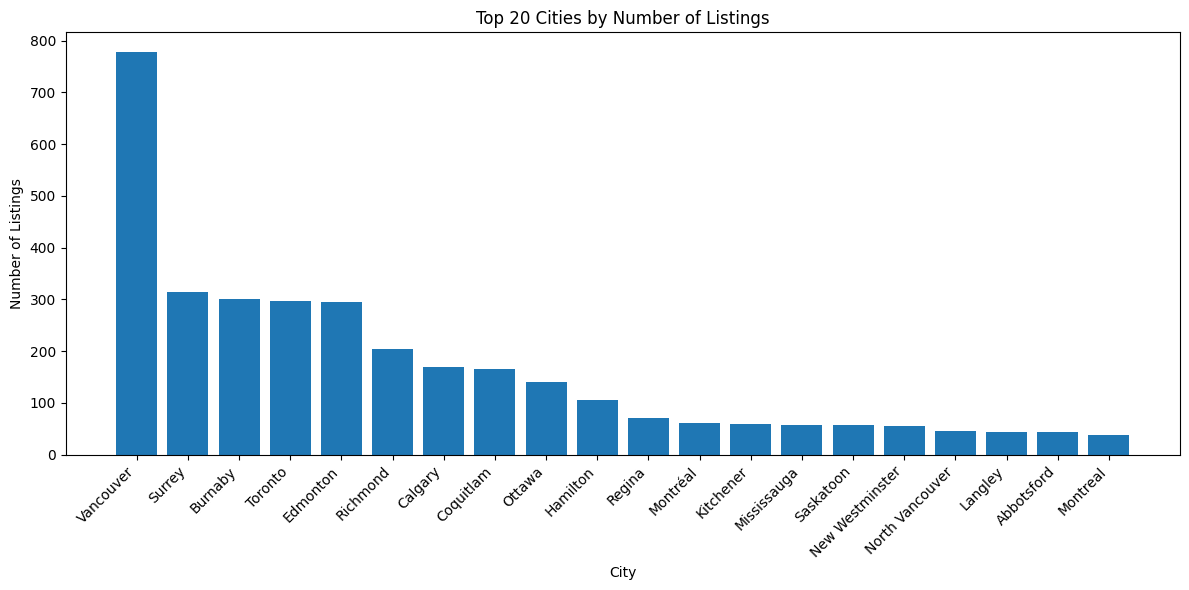

Total number of unique cities: 142
Cities with only 1 listing: 50


In [116]:
# Cidade analysis - Top cities by number of listings
top_cities = dataset['city'].value_counts().head(20)
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_cities)), top_cities.values)
plt.xticks(range(len(top_cities)), top_cities.index, rotation=45, ha='right')
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.title('Top 20 Cities by Number of Listings')
plt.tight_layout()
plt.show()

print(f"Total number of unique cities: {dataset['city'].nunique()}")
print(f"Cities with only 1 listing: {(dataset['city'].value_counts() == 1).sum()}")

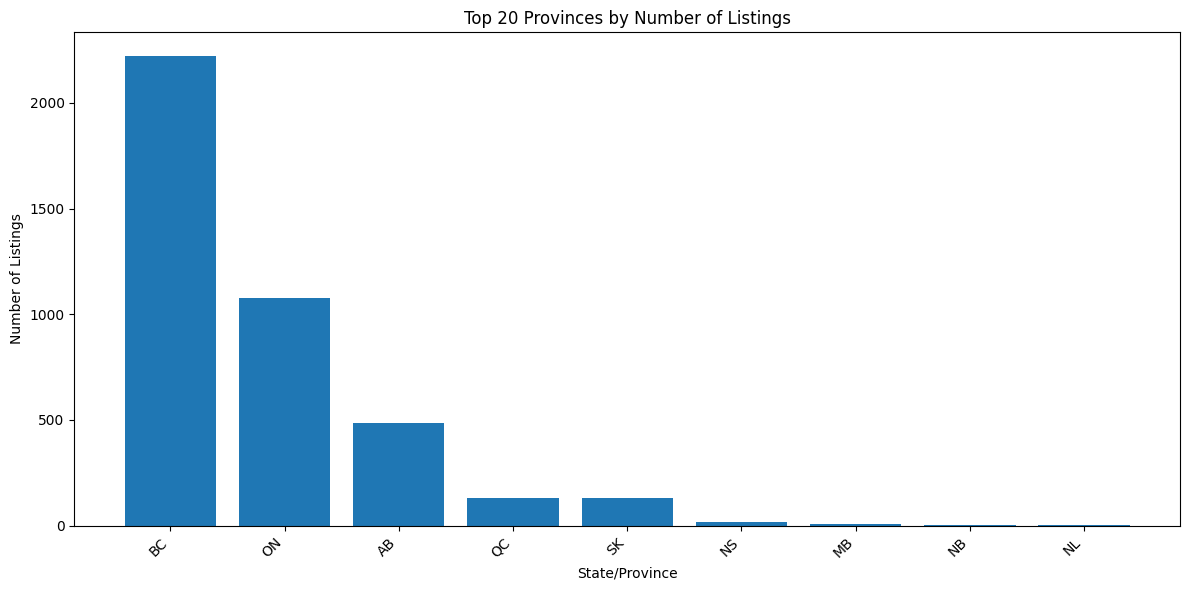

Total number of unique provinces: 142
Provinces with only 1 listing: 50


In [117]:
# State analysis - Top states by number of listings
top_states = dataset['state'].value_counts().head(20)
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_states)), top_states.values)
plt.xticks(range(len(top_states)), top_states.index, rotation=45, ha='right')
plt.xlabel('State/Province')
plt.ylabel('Number of Listings')
plt.title('Top 20 Provinces by Number of Listings')
plt.tight_layout()
plt.show()

print(f"Total number of unique provinces: {dataset['city'].nunique()}")
print(f"Provinces with only 1 listing: {(dataset['city'].value_counts() == 1).sum()}")



In [118]:
# 3D analysis - State vs Número de Bedrooms vs Price (Plotly guarded)
if plotly_available:
    state_bedroom_price = dataset.groupby(['state', 'total_rooms'])['price'].mean().reset_index()
    top_5_provinces = ['BC', 'ON', 'AB', 'QC', 'SK']
    state_bedroom_price_filtered = state_bedroom_price[state_bedroom_price['state'].isin(top_5_provinces)]
    fig = px.scatter_3d(state_bedroom_price_filtered, x='total_rooms', y='state', z='price', color='state', size='price', title='Average Price by Top 5 States and Number of Bedrooms')
    fig.update_layout(scene = dict(xaxis_title='Number of Bedrooms', yaxis_title='State', zaxis_title='Average Price ($)'))
    fig.show()
else:
    print('Skipping Plotly 3D plot (plotly not available)')
print()
print('Note: This 3D plot shows the average price for each combination of State and Número de Bedrooms, filtered for the top 5 states.')
print('The size and color of the points represent the average price for better visualization.')



Note: This 3D plot shows the average price for each combination of State and Número de Bedrooms, filtered for the top 5 states.
The size and color of the points represent the average price for better visualization.


## 11. Preparação de Dados para Modelagem

In [119]:
# IMPORTANT: Select features WITHOUT city (solving high cardinality problem)
print("=" * 80)
print("FEATURE SELECTION - REMOVING HIGH CARDINALITY FEATURES")
print("=" * 80)

print(f"\nOriginal number of cities: {dataset['city'].nunique()}")
print("Problem: One-hot encoding would create 143+ features for cities alone!")
print("Solution: Use longitude/latitude to capture geographic patterns")

# Select features for modeling
feature_columns = [
    # Geographic features (instead of city names)
    'longitude',
    'latitude',

    # Low cardinality categorical features
    'state',  # Only 11 categories
    'building_type_txt_id',  # Only 4-5 categories

    # Numerical features
    'total_rooms',
    'total_bathrooms',
    'size',
    'allow_pets',
    'allow_smoking',
    'furnished',
    'count_private_parking',
    'student_friendly',

    # Target
    'price'
]

# Create modeling dataset
model_data = dataset[feature_columns].copy()

print(f"\nSelected {len(feature_columns)-1} features (excluding target)")
print(f"Dataset shape: {model_data.shape}")

FEATURE SELECTION - REMOVING HIGH CARDINALITY FEATURES

Original number of cities: 142
Problem: One-hot encoding would create 143+ features for cities alone!
Solution: Use longitude/latitude to capture geographic patterns

Selected 12 features (excluding target)
Dataset shape: (4074, 13)


In [120]:
# Handle missing values
print("\nHandling missing values...")

# Numeric columns - fill with median
numeric_columns = ['total_rooms', 'total_bathrooms', 'size', 'count_private_parking',
                  'longitude', 'latitude']
for col in numeric_columns:
    if col in model_data.columns:
        missing_count = model_data[col].isnull().sum()
        if missing_count > 0:
            model_data[col].fillna(model_data[col].median(), inplace=True)
            print(f"  {col}: filled {missing_count} missing values with median")

# Boolean columns - fill with 0 (False)
boolean_columns = ['allow_pets', 'allow_smoking', 'furnished', 'student_friendly']
for col in boolean_columns:
    if col in model_data.columns:
        missing_count = model_data[col].isnull().sum()
        if missing_count > 0:
            model_data[col].fillna(0, inplace=True)
            print(f"  {col}: filled {missing_count} missing values with 0")

# Categorical columns - fill with mode
categorical_columns = ['state', 'building_type_txt_id']
for col in categorical_columns:
    if col in model_data.columns:
        missing_count = model_data[col].isnull().sum()
        if missing_count > 0:
            mode_value = model_data[col].mode()[0] if not model_data[col].mode().empty else 'unknown'
            model_data[col].fillna(mode_value, inplace=True)
            print(f"  {col}: filled {missing_count} missing values with mode ({mode_value})")

print(f"\nRemaining missing values: {model_data.isnull().sum().sum()}")


Handling missing values...
  count_private_parking: filled 2183 missing values with median
  allow_smoking: filled 17 missing values with 0
  furnished: filled 342 missing values with 0

Remaining missing values: 0


## 12. Divisão Treino-Testee

In [121]:
# Stratified train-test split by size_category × total_rooms × total_bathrooms
# Ensure alignment between dataset and model_data
dataset = dataset.reset_index(drop=True)
model_data = model_data.reset_index(drop=True)

# Build stratification column
model_data['stratify_col'] = (
    dataset['size_category'].astype(str) + '_' +
    dataset['total_rooms'].astype(str) + '_' +
    dataset['total_bathrooms'].astype(str)
)

# Replace rare classes with 'Rare'
rare = model_data['stratify_col'].value_counts()
rare = rare[rare < 2].index
model_data['stratify_col'] = model_data['stratify_col'].replace(rare, 'Rare')

# Separate features and target
X = model_data.drop(['price', 'stratify_col'], axis=1)
y = model_data['price']

# Perform stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(model_data, model_data['stratify_col']):
    X_train = X.loc[train_idx]
    X_test = X.loc[test_idx]
    y_train = y.loc[train_idx]
    y_test = y.loc[test_idx]

# Clean up temporary column
model_data.drop(columns=['stratify_col'], inplace=True)

print(f"Conjunto de treino: {X_train.shape} -> {len(X_train)} amostras, {X_train.shape[1]} features")
print(f"Conjunto de teste: {X_test.shape} -> {len(X_test)} amostras")
print(f"\nEstatísticas do alvo:")
print(f"  Treino - Média: ${y_train.mean():.2f}, Std: ${y_train.std():.2f}")
print(f"  Teste  - Média: ${y_test.mean():.2f}, Std: ${y_test.std():.2f}")


Conjunto de treino: (3259, 12) -> 3259 amostras, 12 features
Conjunto de teste: (815, 12) -> 815 amostras

Estatísticas do alvo:
  Treino - Média: $2357.05, Std: $1029.03
  Teste  - Média: $2329.08, Std: $992.23


## 13. Pipeline de Pré-processamento

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define column types
numeric_features = ['longitude', 'latitude', 'total_rooms', 'total_bathrooms',
                   'size', 'allow_pets', 'allow_smoking', 'furnished',
                   'count_private_parking', 'student_friendly']
categorical_features = ['state', 'building_type_txt_id']

print("Criando pipeline de pré-processamento...")
print(f"  Features numéricas ({len(numeric_features)}): {numeric_features}")
print(f"  Features categóricas ({len(categorical_features)}): {categorical_features}")

# Create preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform training data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print(f"\nFormato dos dados preparados:")
print(f"  Treino: {X_train_prepared.shape}")
print(f"  Teste: {X_test_prepared.shape}")
print(f"\nTotal de features após pré-processamento: {X_train_prepared.shape[1]}")

Criando pipeline de pré-processamento...
  Features numéricas (10): ['longitude', 'latitude', 'total_rooms', 'total_bathrooms', 'size', 'allow_pets', 'allow_smoking', 'furnished', 'count_private_parking', 'student_friendly']
  Features categóricas (2): ['state', 'building_type_txt_id']

Formato dos dados preparados:
  Treino: (3259, 21)
  Teste: (815, 21)

Total de features após pré-processamento: 21


In [123]:
# Get feature names after preprocessing
feature_names = numeric_features.copy()

# Add one-hot encoded feature names
if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
else:
    # For older sklearn versions
    cat_features = []
    for cat in categorical_features:
        unique_vals = X_train[cat].unique()
        # Skip first value due to drop='first'
        for val in sorted(unique_vals)[1:]:
            cat_features.append(f"{cat}_{val}")

feature_names.extend(cat_features)

print(f"\nNomes das features após pré-processamento ({len(feature_names)} total):")
for i, name in enumerate(feature_names):
    print(f"  {i:3}: {name}")


Nomes das features após pré-processamento (21 total):
    0: longitude
    1: latitude
    2: total_rooms
    3: total_bathrooms
    4: size
    5: allow_pets
    6: allow_smoking
    7: furnished
    8: count_private_parking
    9: student_friendly
   10: state_BC
   11: state_MB
   12: state_NB
   13: state_NL
   14: state_NS
   15: state_ON
   16: state_QC
   17: state_SK
   18: building_type_txt_id_house
   19: building_type_txt_id_lowrise
   20: building_type_txt_id_townhouse


## 14. Treinamento de Modelos - Comparação de Múltiplos Modelos

In [124]:
# Dictionary to store models and results
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = []

print("Treinando e avaliando modelos...\n")
print("=" * 80)

for name, model in models.items():
    print(f"\nTreinando {name}...")

    # Treino model
    model.fit(X_train_prepared, y_train)

    # Fazer previsões
    y_pred_train = model.predict(X_train_prepared)
    y_pred_test = model.predict(X_test_prepared)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store results
    results.append({
        'Model': name,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Overfitting': train_r2 - test_r2
    })

    print(f"  Treino MAE: ${train_mae:.2f}")
    print(f"  Teste MAE: ${test_mae:.2f}")
    print(f"  Treino R²: {train_r2:.4f}")
    print(f"  Teste R²: {test_r2:.4f}")
    print(f"  Sobreajuste: {train_r2 - test_r2:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("\nResumo da Comparação de Modelos:")
print(results_df.round(4))

Treinando e avaliando modelos...


Treinando Linear Regression...
  Treino MAE: $377.55
  Teste MAE: $374.62
  Treino R²: 0.6830
  Teste R²: 0.6828
  Sobreajuste: 0.0002

Treinando Decision Tree...
  Treino MAE: $156.24
  Teste MAE: $299.47
  Treino R²: 0.9483
  Teste R²: 0.7422
  Sobreajuste: 0.2062

Treinando Random Forest...
  Treino MAE: $90.57
  Teste MAE: $232.66
  Treino R²: 0.9769
  Teste R²: 0.8580
  Sobreajuste: 0.1189


Resumo da Comparação de Modelos:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  \
0  Linear Regression    377.551   374.618     579.311    558.512     0.683   
1      Decision Tree    156.236   299.472     233.879    503.507     0.948   
2      Random Forest     90.573   232.662     156.456    373.679     0.977   

   Test R²  Overfitting  
0    0.683        0.000  
1    0.742        0.206  
2    0.858        0.119  


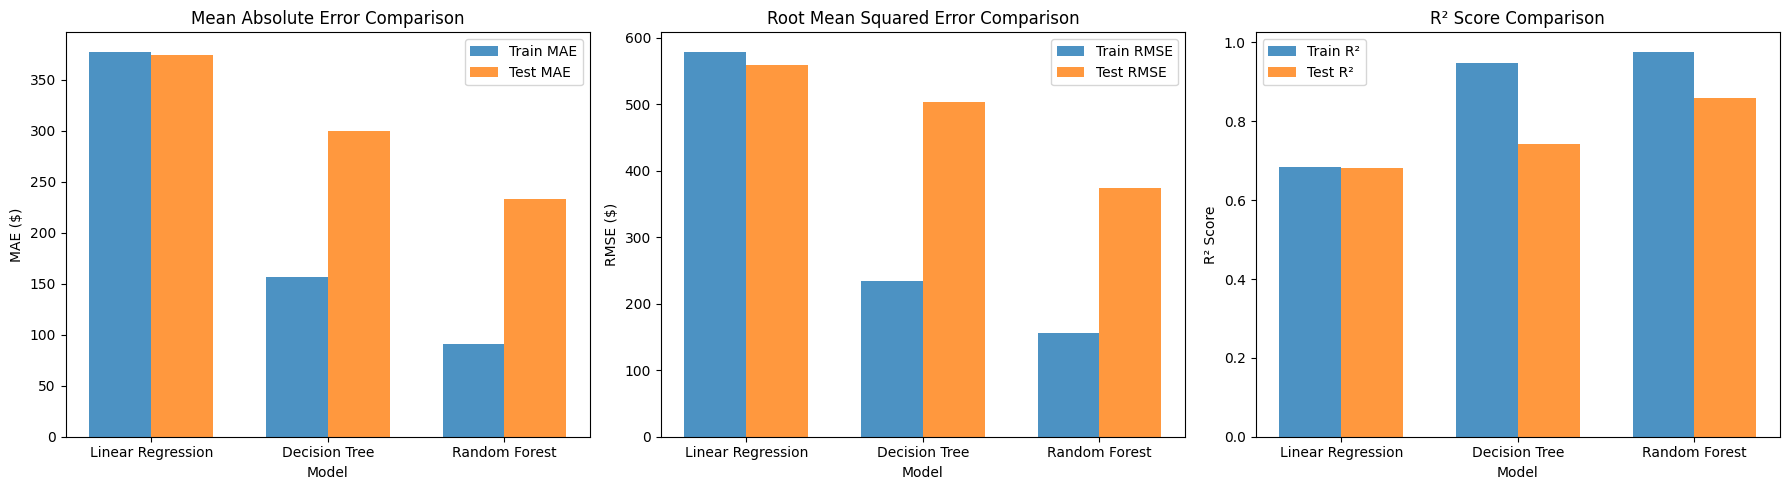

In [125]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
x = np.arange(len(results_df))
width = 0.35
axes[0].bar(x - width/2, results_df['Train MAE'], width, label='Train MAE', alpha=0.8)
axes[0].bar(x + width/2, results_df['Test MAE'], width, label='Test MAE', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE ($)')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'])
axes[0].legend()

# RMSE comparison
axes[1].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE ($)')
axes[1].set_title('Root Mean Squared Error Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'])
axes[1].legend()

# R² comparison
axes[2].bar(x - width/2, results_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[2].bar(x + width/2, results_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(results_df['Model'])
axes[2].legend()

plt.tight_layout()
plt.show()

## 15. Validação Cruzada para o Melhor Modelo

In [126]:
# Selecionar melhor modelo (Random Forest)
best_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)

# Cross-validation
print("Realizando validação cruzada 5-fold on Random Forest...")
cv_scores = cross_val_score(best_model, X_train_prepared, y_train,
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=1)

print(f"\nResultados da validação cruzada:")
print(f"  Pontuações MAE: {-cv_scores}")
print(f"  MAE Médio: ${-cv_scores.mean():.2f}")
print(f"  Desvio Padrão MAE: ${cv_scores.std():.2f}")
print(f"  95% CI: ${-cv_scores.mean():.2f} ± ${1.96 * cv_scores.std():.2f}")

Realizando validação cruzada 5-fold on Random Forest...

Resultados da validação cruzada:
  Pontuações MAE: [241.69143327 251.74125032 223.91503505 274.13483309 241.75316694]
  MAE Médio: $246.65
  Desvio Padrão MAE: $16.41
  95% CI: $246.65 ± $32.17


## 16. Análise de Importância de Features

Top 15 Features Mais Importantes:
                       feature  importance
               total_bathrooms       0.413
                          size       0.188
                      latitude       0.176
                     longitude       0.165
                   total_rooms       0.031
    building_type_txt_id_house       0.009
                     furnished       0.007
                    allow_pets       0.004
         count_private_parking       0.002
building_type_txt_id_townhouse       0.002
                      state_QC       0.001
  building_type_txt_id_lowrise       0.001
                      state_ON       0.000
                      state_BC       0.000
                 allow_smoking       0.000


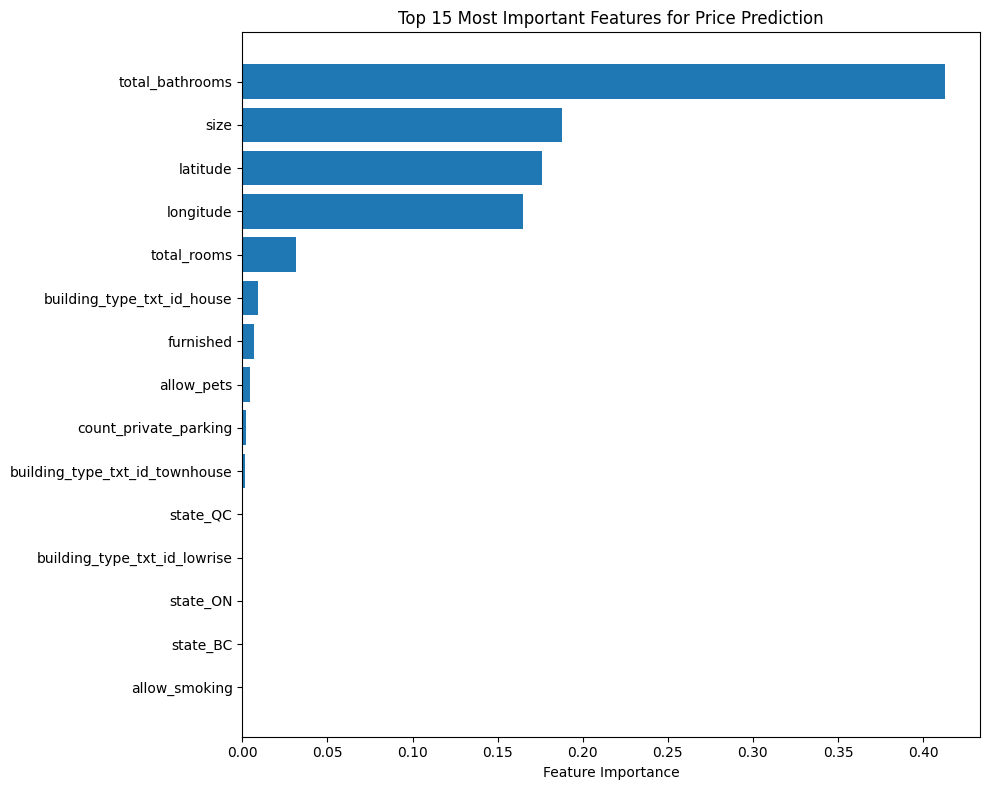


Observação: Longitude e Latitude estão entre as features principais, validando nossa abordagem!


In [127]:
# Treinar final Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_prepared, y_train)

# Obter importâncias das features
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top features
print("Top 15 Features Mais Importantes:")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Price Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nObservação: Longitude e Latitude estão entre as features principais, validando nossa abordagem!")

## 17. Análise de Previsões

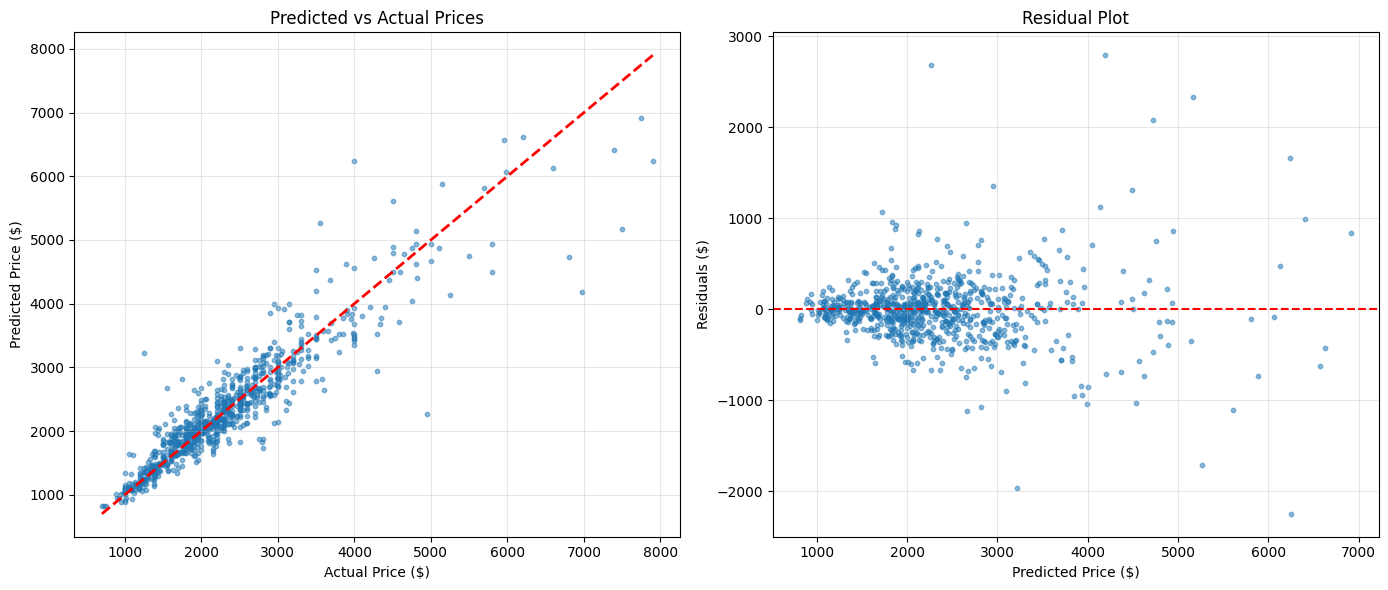

Análise de Resíduos:
  Resíduo médio: $-7.14
  Desvio padrão do resíduo: $373.84
  Resíduo mínimo: $-2246.37
  Resíduo máximo: $2790.48


In [128]:
# Fazer previsões no conjunto de teste
y_pred_test = rf_model.predict(X_test_prepared)

# Gráfico de Previsão vs Real
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de dispersão
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title('Predicted vs Actual Prices')
axes[0].grid(True, alpha=0.3)

# Gráfico de resíduos
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("Análise de Resíduos:")
print(f"  Resíduo médio: ${residuals.mean():.2f}")
print(f"  Desvio padrão do resíduo: ${residuals.std():.2f}")
print(f"  Resíduo mínimo: ${residuals.min():.2f}")
print(f"  Resíduo máximo: ${residuals.max():.2f}")

## 18. Salvar Modelo Final e Pipeline

In [129]:
# Criar um pipeline completo with preprocessing and model
complete_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# Ajustar o pipeline completo
complete_pipeline.fit(X_train, y_train)

# Salvar o pipeline
model_filename = 'random_forest_rental_price_model_v1_35.pkl'
joblib.dump(complete_pipeline, model_filename)
print(f"Modelo salvo como: {model_filename}")

# Salvar informações das features
feature_info = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'all_features': feature_names,
    'n_features': len(feature_names),
    'model_version': '1.34',
    'improvements': 'Complete EDA + Removed city one-hot encoding',
    'test_mae': float(test_mae),
    'test_rmse': float(test_rmse),
    'test_r2': float(test_r2)
}

import json
with open('model_features_v1_35.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("Informações das features salvas como: model_features_v1_35.json")

Modelo salvo como: random_forest_rental_price_model_v1_35.pkl
Informações das features salvas como: model_features_v1_35.json


## 19. Testear o Modelo Salvo

In [130]:
# Carregar o modelo salvo
loaded_pipeline = joblib.load(model_filename)

# Criar amostras de teste
test_samples = pd.DataFrame({
    'longitude': [-79.4163, -123.1207, -114.0719],
    'latitude': [43.70011, 49.2827, 51.0447],
    'state': ['ON', 'BC', 'AB'],
    'building_type_txt_id': ['highrise', 'apartment', 'house'],
    'total_rooms': [2, 1, 3],
    'total_bathrooms': [2, 1, 2],
    'size': [700, 500, 1200],
    'allow_pets': [1, 0, 1],
    'allow_smoking': [0, 0, 1],
    'furnished': [0, 1, 0],
    'count_private_parking': [1, 0, 2],
    'student_friendly': [0, 1, 0]
})

# Fazer previsões
predictions = loaded_pipeline.predict(test_samples)

print("Previsões de Testee:")
for i, pred in enumerate(predictions):
    print(f"\nAmostra {i+1}:")
    print(f"  Localização: {test_samples.iloc[i]['state']} ({test_samples.iloc[i]['latitude']:.2f}, {test_samples.iloc[i]['longitude']:.2f})")
    print(f"  Tipo: {test_samples.iloc[i]['building_type_txt_id']}")
    print(f"  Quartos: {test_samples.iloc[i]['total_rooms']}, Tamanho: {test_samples.iloc[i]['size']} sqft")
    print(f"  Preço Previsto: ${pred:.2f}")

Previsões de Testee:

Amostra 1:
  Localização: ON (43.70, -79.42)
  Tipo: highrise
  Quartos: 2, Tamanho: 700 sqft
  Preço Previsto: $2863.82

Amostra 2:
  Localização: BC (49.28, -123.12)
  Tipo: apartment
  Quartos: 1, Tamanho: 500 sqft
  Preço Previsto: $2499.98

Amostra 3:
  Localização: AB (51.04, -114.07)
  Tipo: house
  Quartos: 3, Tamanho: 1200 sqft
  Preço Previsto: $2285.95


## 20. Resumo do Modelo e Conclusões

In [131]:
print("=" * 80)
print("RESUMO DO MODELO - Versão 1.34")
print("=" * 80)
print(f"\nEstatísticas do Dataset:")
print(f"  Total de amostras: {len(dataset)}")
print(f"  Amostras de treino: {len(X_train)}")
print(f"  Amostras de teste: {len(X_test)}")
print(f"\nEngenharia de Features:")
print(f"  Total de features: {len(feature_names)}")
print(f"    - Features numéricas: {len(numeric_features)}")
print(f"    - Features categóricas: {len(categorical_features)} (codificadas one-hot para ~{len(feature_names)-len(numeric_features)} features)")
print(f"\nMelhorias Principais:")
print("  ✓ EDA completa com visualizações")
print("  ✓ Detecção e remoção de outliers")
print("  ✓ Correlation analysis")
print("  ✓ Comparação de múltiplos modelos")
print("  ✓ Removida codificação one-hot de cidade (was 143 features)")
print("  ✓ Usando longitude/latitude para localização")
print("  ✓ Funciona com QUALQUER cidade, mesmo as não vistas")
print(f"\nPerformance do Melhor Modelo (Random Forest):")
print(f"  - Teste MAE: ${test_mae:.2f}")
print(f"  - Teste RMSE: ${test_rmse:.2f}")
print(f"  - Teste R²: {test_r2:.4f}")
print(f"\nTop 3 Features Mais Importantes:")
for i in range(3):
    print(f"  {i+1}. {feature_importance.iloc[i]['feature']}: {feature_importance.iloc[i]['importance']:.4f}")
print("=" * 80)

RESUMO DO MODELO - Versão 1.34

Estatísticas do Dataset:
  Total de amostras: 4074
  Amostras de treino: 3259
  Amostras de teste: 815

Engenharia de Features:
  Total de features: 21
    - Features numéricas: 10
    - Features categóricas: 2 (codificadas one-hot para ~11 features)

Melhorias Principais:
  ✓ EDA completa com visualizações
  ✓ Detecção e remoção de outliers
  ✓ Correlation analysis
  ✓ Comparação de múltiplos modelos
  ✓ Removida codificação one-hot de cidade (was 143 features)
  ✓ Usando longitude/latitude para localização
  ✓ Funciona com QUALQUER cidade, mesmo as não vistas

Performance do Melhor Modelo (Random Forest):
  - Teste MAE: $232.66
  - Teste RMSE: $373.68
  - Teste R²: 0.8580

Top 3 Features Mais Importantes:
  1. total_bathrooms: 0.4128
  2. size: 0.1879
  3. latitude: 0.1763


## Instruções de Download

Após o treinamento, geramos estes arquivos:
1. `random_forest_rental_price_model_v1_35.pkl` - O pipeline completo (pré-processamento + modelo)
2. `model_features_v1_35.json` - Informações de features e metadados

Estes arquivos contêm tudo que é necessário para implantar o modelo em produção.

In [132]:
# Copy to Google Drive for easy download (guarded)
import shutil, os
drive_path = '/content/drive/MyDrive/AI/price_prediction/'
try:
    if os.path.exists(drive_path):
        shutil.copy(model_filename, os.path.join(drive_path, model_filename))
        shutil.copy('model_features_v1_35.json', os.path.join(drive_path, 'model_features_v1_35.json'))
        print('Arquivos copiados para o Google Drive para download')
    else:
        print('Skipping copy to Google Drive: drive path not found')
except Exception as e:
    print('Skipping copy to Google Drive due to error:', e)


Arquivos copiados para o Google Drive para download
